In [1]:
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Research import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.stats as ss
import numpy as np
from pykalman import KalmanFilter
import statsmodels.tsa.stattools as sm
import pandas as pd
qb = QuantBook()

s1 = qb.AddEquity("adbe")
s2 = qb.AddEquity("intu")
start_date = datetime(2016,1,1)
end_date = datetime(2018,1,1)
hedge_lookback = 21*3
dist = 253
entry = 1.5
zstop = 3
exit = 0.5

series1 = qb.History(s1.Symbol, start_date, end_date, Resolution.Daily).close.values.tolist()
series2 = qb.History(s2.Symbol, start_date, end_date, Resolution.Daily).close.values.tolist()

In [2]:
def get_og_spreads(series1, series2, length):
    spreads = []
    for i in range(length):
        start_index = len(series1) - length + i
        X = sm.add_constant(series2[(start_index-hedge_lookback):start_index])
        model = sm.OLS(series1[(start_index-hedge_lookback):start_index], X)
        results = model.fit()
        resid = results.resid[-1]
        spreads = np.append(spreads, resid)
    normalized_spreads = ss.zscore(spreads)
    return spreads, normalized_spreads

og_spreads, og_zscores = get_og_spreads(np.log(series1),np.log(series2),dist)

In [3]:
def get_simple_spreads(series1,series2,length):
    spreads = np.array(series1[-length:]) - np.array(series2[-length:])
    normalized_spreads = ss.zscore(spreads)
    return spreads, normalized_spreads

simple_spreads, simple_zscores = get_simple_spreads(series1,series2, dist)
logged_spreads, logged_zscores = get_simple_spreads(np.log(series1),np.log(series2), dist)

In [4]:
def get_pct_spreads(series1,series2,length):
    series1_df = pd.DataFrame(series1)
    series2_df = pd.DataFrame(series2)
    series1_changes = pd.DataFrame.pct_change(series1_df)
    series2_changes = pd.DataFrame.pct_change(series2_df)
    spreads = np.array(series1_changes[-length:]) - np.array(series2_changes[-length:])
    normalized_spreads = ss.zscore(spreads)
    return spreads, normalized_spreads

pct_spreads, pct_zscores = get_pct_spreads(series1,series2, dist)

In [5]:
def get_ratio_spreads(series1,series2,length):
    spreads = np.array(series1[-length:])/np.array(series2[-length:])
    normalized_spreads = ss.zscore(spreads)
    return spreads, normalized_spreads

ratio_spreads, ratio_zscores = get_ratio_spreads(series1,series2, dist)

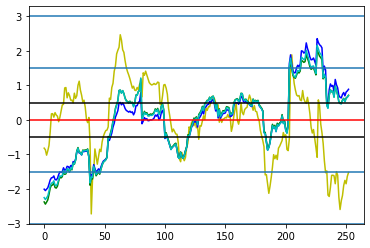

In [6]:
plt.plot(og_zscores, color= 'y')
plt.plot(simple_zscores, color= 'b')
plt.plot(logged_zscores, color= 'g')
plt.plot(ratio_zscores, color= 'c')

plt.axhline(y=entry)
plt.axhline(y=-entry)
plt.axhline(y=0, color='r')
plt.axhline(y=zstop)
plt.axhline(y=-zstop)
plt.axhline(y=exit, color='k')
plt.axhline(y=-exit, color='k')

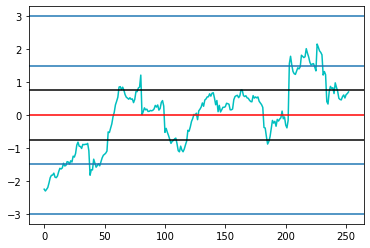

In [7]:
plt.plot(ratio_zscores, color= 'c')
plt.axhline(y=entry)
plt.axhline(y=-entry)
plt.axhline(y=0, color='r')
plt.axhline(y=zstop)
plt.axhline(y=-zstop)
plt.axhline(y=0.75, color='k')
plt.axhline(y=-0.75, color='k')